In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'appa-real-face-cropped:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F182089%2F408793%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240607%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240607T165612Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da11bf53ae979d0983e64281c0af8b8c7d83054cc264b24a320258bfa577e2dd074fe931af8451d5826f8d5d48ed5792d060b93a2153a649e5b1fe8c81685b49ccdeb044d919c799d7a64b66d16fa299d9917d0bc1dffe1eabc17ffe54f229a86aa4defbb9321acaadf4891ea237f81686c4ddb082bcaf5131855c612e83408e55fc12e6cb276760fddd55f9d4c9a2ee33b53325abc08d3a470ff3d3de174760f61205801b83e8187bb742f47cade6686fa50705105ee639d61d3a4cd5b915f2611efd30eaefd62b91c878250ca50e48aefbf541917cce793161a86dad1cf9565bcc79c66f25813062fc57c615f3a88bdd4a61425a12d29df957d24e9dc66089f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 239508859 bytes downloaded
Downloaded and uncompressed: appa-real-face-cropped
Data source import complete.


# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
!python --version

Python 3.10.12


In [ ]:
RANDOM_SEED = 12345

In [ ]:
labels = pd.read_csv('/kaggle/input/appa-real-face-cropped/labels.csv')
display(labels.head())
labels.shape

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


(7591, 2)

<Axes: >

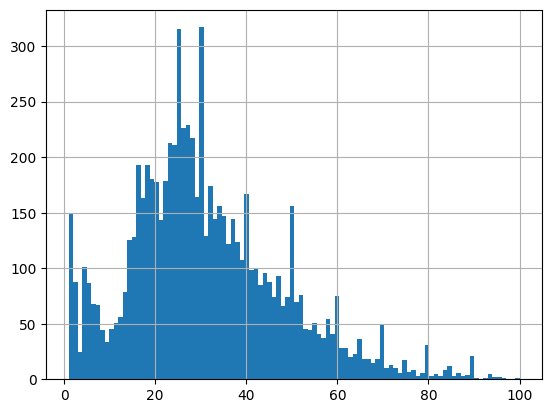

In [ ]:
labels['real_age'].hist(bins=100)

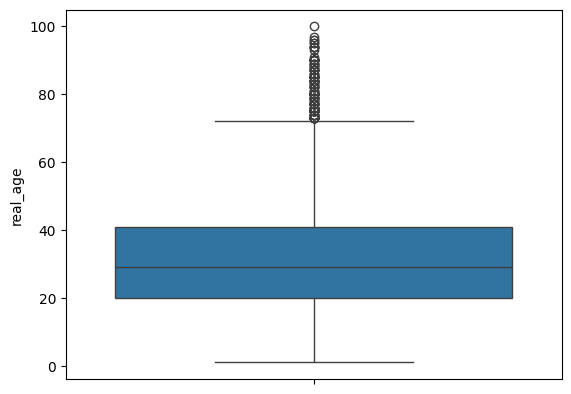

In [ ]:
ax = sns.boxplot(labels['real_age'])
# ax.set_xlim([10, 50])
plt.show()

Гистограмма распределения по возрасту скошена влево, так как фотографий людей старше 50 лет в датасете значительно меньше, чем людей других возрастов. Большая часть людей на фотографиях - в возрасте от 20 до 41 года.

In [ ]:
labels['real_age'].max()

100

In [ ]:
labels['real_age'].min()

1

Found 7591 validated image filenames.


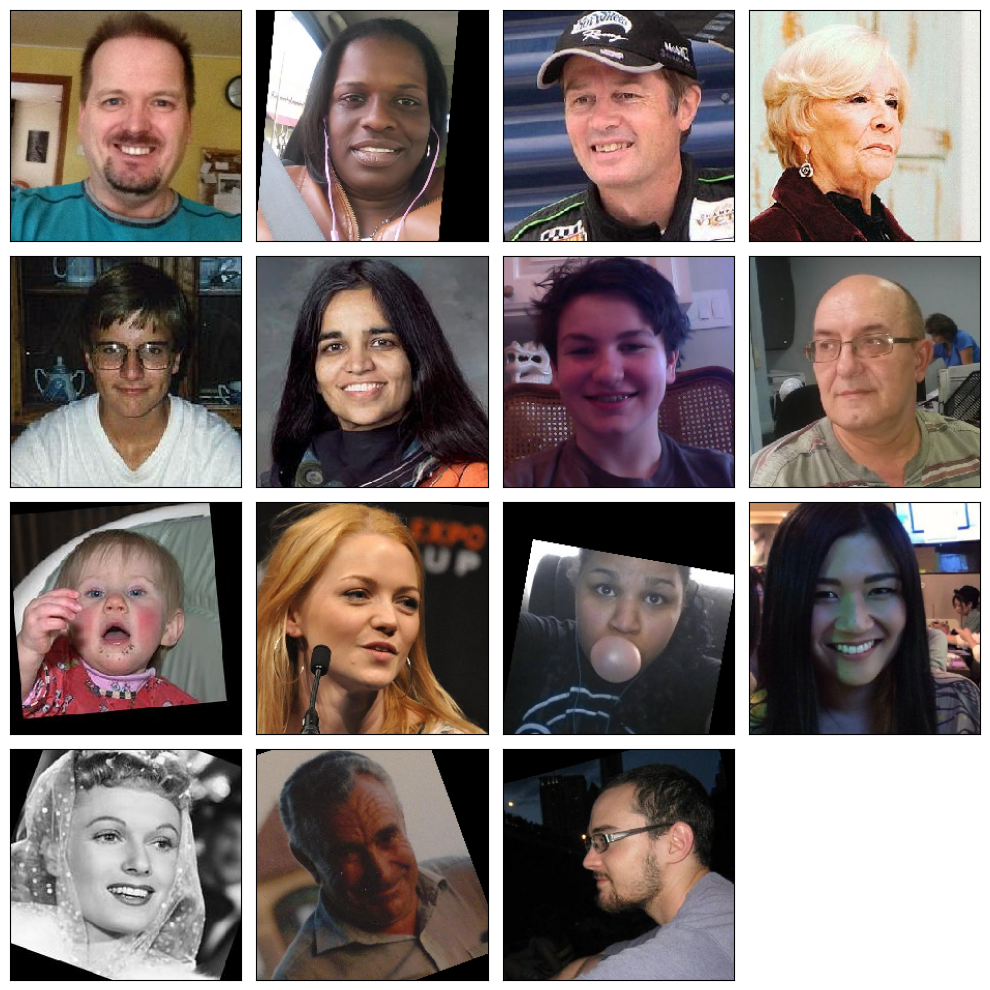

In [ ]:
path = '/kaggle/input/appa-real-face-cropped/final_files/final_files'

datagen = ImageDataGenerator(
    rescale=1/255
)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=RANDOM_SEED
)

features, target = next(datagen_flow)

fig = plt.figure(figsize=(10, 10))

for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Размер датасета - 7591 фотография - этого достаточно для решения поставленной задачи.
Минимальный возраст людей на фотографиях - 1 год, максимальный - 100 лет. Большая часть людей на фотографиях - в возрасте от 20 до 41 года.
В данных видим фотографии людей разного возраста, пола, национальности. Есть фото, расположенные под углом.
Большая часть фотографий - крупным планом, в профиль и в анфас.

## Обучение модели

In [ ]:
def load_train():
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255,
        horizontal_flip=True,
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=RANDOM_SEED
    )

    features, target = next(datagen_flow)

    return features, target

def load_test():
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=RANDOM_SEED
    )

    features, target = next(datagen_flow)

    return features, target

def create_model(input_shape):
    backbone = ResNet50(
        # input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])
    return model

def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=30,
    steps_per_epoch=None,
    validation_steps=None):

    features_train, target_train = train_data
    features_test, target_test = test_data

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        features_train, target_train,
        validation_data=(features_test, target_test),
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    return model

In [ ]:
if __name__ == '__main__':
    train_data = load_train()
    test_data = load_test()
    input_shape = train_data[0].shape[1:]
    model = create_model(input_shape)
    model = train_model(model, train_data, test_data)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/30
2/2 - 54s - loss: 1321.1091 - mae: 31.1908 - val_loss: 1246.1875 - val_mae: 32.3125 - 54s/epoch - 27s/step
Epoch 2/30
2/2 - 28s - loss: 1196.3356 - mae: 29.5729 - val_loss: 1246.1875 - val_mae: 32.3125 - 28s/epoch - 14s/step
Epoch 3/30
2/2 - 27s - loss: 1073.5809 - mae: 28.1607 - val_loss: 1246.1875 - val_mae: 32.3125 - 27s/epoch - 13s/step
Epoch 4/30
2/2 - 27s - loss: 952.5239 - mae: 26.7781 - val_loss: 1246.1875 - val_mae: 32.3125 - 27s/epoch - 13s/step
Epoch 5/30
2/2 - 31s - loss: 830.4843 - mae: 25.0857 - val_loss: 1246.1875 - val_mae: 32.3125 - 31s/epoch - 15s/step
Epoch 6/30
2/2 - 27s - loss: 753.8390 - mae: 23.5068 - val_loss: 1246.1875 - val_mae: 32.3125 - 27s/epoch - 14s/step
Epoch 7/30
2/2 - 27s - loss: 707.6406 - mae: 22.6761 - val_loss: 1246.1875 - val_mae: 32.3125 - 27s/epoch - 13s/step
Epoch 8/30
2/2 - 27s - loss: 663.6458 - mae: 20.7461 - val_loss: 1246.1875 - val_mae: 32.3125 - 27s/ep

<div class="alert alert-info">
Логи обучения модели:

</div>

2022-09-04 00:03:49.338911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-09-04 00:03:49.340583: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-09-04 00:03:50.199964: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-04 00:03:50.881964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-04 00:03:50.882058: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-09-04 00:03:50.882089: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-04 00:03:50.884067: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-09-04 00:03:50.884447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-09-04 00:03:50.886465: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-09-04 00:03:50.887605: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-09-04 00:03:50.887667: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-09-04 00:03:50.892144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-09-04 00:03:51.485270: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-09-04 00:03:51.492017: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-09-04 00:03:51.492613: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5f48810 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-04 00:03:51.492643: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-04 00:03:51.636386: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5ee5260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-09-04 00:03:51.636426: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-09-04 00:03:51.638777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-04 00:03:51.638842: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-09-04 00:03:51.638852: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-04 00:03:51.638887: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-09-04 00:03:51.638900: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-09-04 00:03:51.638913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-09-04 00:03:51.638924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-09-04 00:03:51.638933: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-09-04 00:03:51.643203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-09-04 00:03:51.643266: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-09-04 00:03:51.956878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-09-04 00:03:51.956933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0
2022-09-04 00:03:51.956941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N
2022-09-04 00:03:51.961401: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-09-04 00:03:51.961450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-09-04 00:04:02.389172: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-04 00:04:02.683673: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 225.9454 - mae: 11.1426 - val_loss: 880.2448 - val_mae: 24.7780
Epoch 2/10
356/356 - 38s - loss: 110.0236 - mae: 7.9751 - val_loss: 235.4315 - val_mae: 11.6701
Epoch 3/10
356/356 - 38s - loss: 88.8594 - mae: 7.1903 - val_loss: 91.6538 - val_mae: 7.3360
Epoch 4/10
356/356 - 39s - loss: 70.4698 - mae: 6.4378 - val_loss: 113.3044 - val_mae: 8.0010
Epoch 5/10
356/356 - 38s - loss: 62.3065 - mae: 6.0745 - val_loss: 114.7161 - val_mae: 8.2634
Epoch 6/10
356/356 - 38s - loss: 53.1135 - mae: 5.5311 - val_loss: 103.8627 - val_mae: 7.2898
Epoch 7/10
356/356 - 38s - loss: 46.8765 - mae: 5.2429 - val_loss: 92.8751 - val_mae: 7.3128
Epoch 8/10
Epoch 9/10
356/356 - 38s - loss: 43.2863 - mae: 5.0131 - val_loss: 108.8269 - val_mae: 8.0183
356/356 - 38s - loss: 36.6373 - mae: 4.6437 - val_loss: 81.0900 - val_mae: 6.7064
Epoch 10/10

## Анализ обученной модели

### Архитектура и параметры обучения

В архитектуре сети для обучения модели использовались:
1. Позвоночник (backbone) - архитектура сети RestNet (которая состоит из 50 сверточных слоев), но с весами, полностью заимствованными у модели, предобученной на датасете ImageNet.
2. Состав головы (head):

1) сначала глобальный двумерный пуллинг с усреднением;

2) затем один полносвязный слой с одним нейроном и функцией активации relu.

Параметры для обучения сети:
- заморозка весов не использовалась
- оптимизатор Adam с шагом 0.001
- обучение на 10 эпохах с разделением на 16 батчей, после каждой эпохи выборку перемешивали
- функция потерь - MSE

Метрика для определения качества модели - MAE.

### Результаты обучения

Функция потерь на обучающей выборке показала результат 36.64, на тестовой 81.1.

MAE на обучающей выборке 4.64, на тестовой выборке 6.7.

Модель показала хороший результат на тестовой выборке, но модель немного переобучилась.

## Как улучшать модель

Оптмизаторы:
- Стохастический градиентный спуск (SGD).
- Оптимизатор импульса (Momentum).
- Среднеквадратичное распространение (RMSProp).
- Адаптивная оценка момента (Adam).

## Чек-лист

- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  MAE модели не больше 8
- [x]  По итогам обучения модели сделаны выводы